In [7]:
import pandas as pd
import numpy as np

In [8]:
data = pd.read_csv('GOOG.csv')
Date1 = data['Date']
Price_G = data['Open']
vol = data['Volume']
p_500 = data['SP500']
btc = data['BTC']
new_data = []
new_data.append(pd.DataFrame({'Date':Date1,
                              'Google': Price_G,
                              'volume': vol,
                              'S&P500': p_500,
                              'BTC': btc
                              }))
new_data_df = pd.concat(new_data)
new_data_df.dropna(inplace=True)
new_data_df.info()
new_data_df['Date'] = pd.to_datetime(new_data_df['Date'])  # Ensure the date column is in datetime format
df = new_data_df.set_index('Date')  # Set the date column as the index of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 2090 entries, 0 to 2089
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2090 non-null   object 
 1   Google  2090 non-null   float64
 2   volume  2090 non-null   int64  
 3   S&P500  2090 non-null   float64
 4   BTC     2090 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 98.0+ KB


In [9]:
df.head()

,Google,volume,S&P500,BTC
Date,,,,
2015-01-02,26.378078,28951268,2058.90,314.08
2015-01-05,26.091366,41196796,2054.44,265.08
2015-01-06,25.679497,57998800,2022.15,274.61
2015-01-07,25.280592,41301082,2005.55,286.08
2015-01-08,24.831326,67071641,2030.61,294.14


In [10]:
# Aplicăm testul ADF pentru fiecare coloană a setului de date
from statsmodels.tsa.stattools import adfuller
for column in df.columns:
    result = adfuller(df[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    print('------')

ADF Statistic for Google: -0.8678386675672475
p-value for Google: 0.7983790618657776
------
ADF Statistic for volume: -12.822008039135978
p-value for volume: 6.124832399565952e-24
------
ADF Statistic for S&P500: -0.8323569176435343
p-value for S&P500: 0.8094322409159103
------
ADF Statistic for BTC: -1.6419779370780303
p-value for BTC: 0.46122745100096735
------


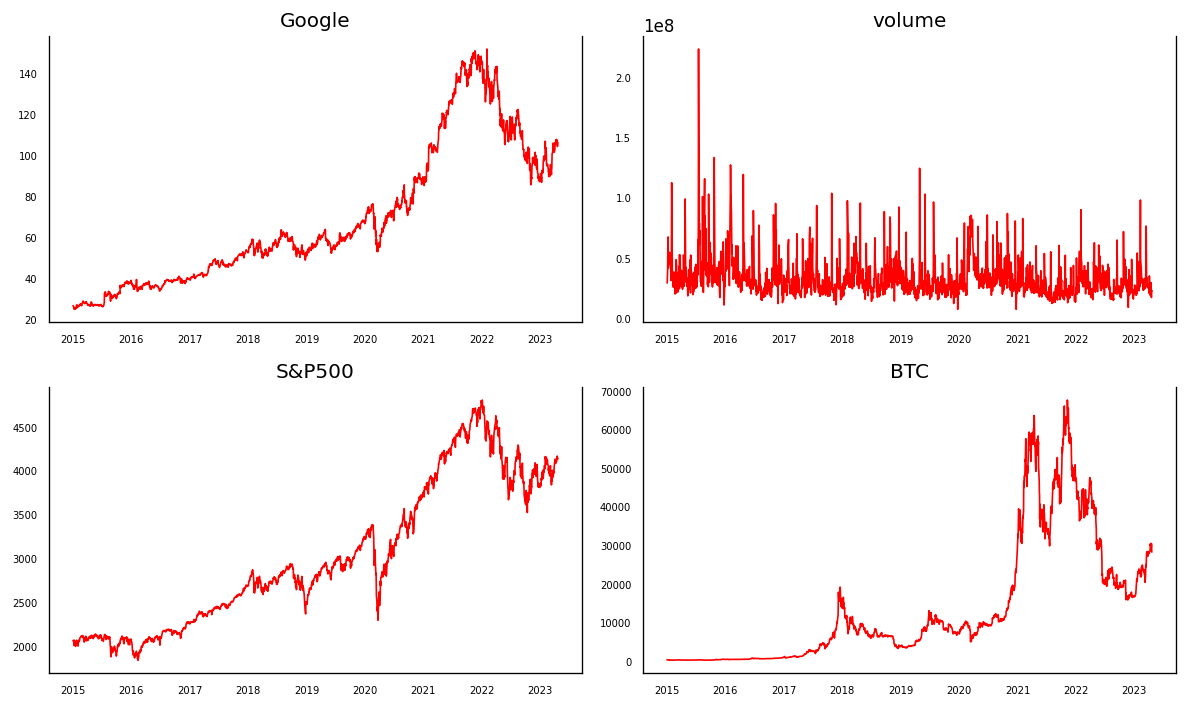

In [11]:
import matplotlib.pyplot as plt
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=20
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Google_x,volume_x,S&P500_x,BTC_x
Google_y,1.000,0.0081,0.2056,0.0001
volume_y,0.000,1.0000,0.0000,0.0000
S&P500_y,0.067,0.0000,1.0000,0.0039
BTC_y,0.000,0.2941,0.0057,1.0000


In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Google ::  166.11    > 40.1749   =>   True
volume ::  26.69     > 24.2761   =>   True
S&P500 ::  3.36      > 12.3212   =>   False
BTC    ::  0.74      > 4.1296    =>   False


In [14]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(2086, 4)
(4, 4)


In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [17]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Google" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8909
 No. Lags Chosen       = 23
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.791. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "volume" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.8333
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "S&P500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

In [18]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [20]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Google" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.1572
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "volume" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5028
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "S&P500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [22]:
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  53.46758310614927
BIC :  53.52172940560103
FPE :  1.6621733684087014e+23
HQIC:  53.48742312840227 

Lag Order = 2
AIC :  53.40816594696436
BIC :  53.50566778080277
FPE :  1.5662888371689726e+23
HQIC:  53.44389296057216 

Lag Order = 3
AIC :  53.407269771619525
BIC :  53.548161405124375
FPE :  1.564886475804448e+23
HQIC:  53.45889710547937 

Lag Order = 4
AIC :  53.3875457023002
BIC :  53.571861444825316
FPE :  1.5343241904374204e+23
HQIC:  53.45508670294874 

Lag Order = 5
AIC :  53.38552866810774
BIC :  53.6133028731589
FPE :  1.5312345014295856e+23
HQIC:  53.46899669975278 

Lag Order = 6
AIC :  53.385261767187124
BIC :  53.656528832500165
FPE :  1.5308287655804576e+23
HQIC:  53.48467021173944 

Lag Order = 7
AIC :  53.37193109617012
BIC :  53.68672546378921
FPE :  1.5105611529869552e+23
HQIC:  53.487293353275376 

Lag Order = 8
AIC :  53.3732750738774
BIC :  53.73163123023351
FPE :  1.51259789399954e+23
HQIC:  53.5046045609481 

Lag Order = 9
AIC :  53.371240788

c:\Users\razva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,53.59,53.60,1.869e+23,53.59
1,53.48,53.54,1.684e+23,53.50
2,53.42,53.52*,1.585e+23,53.46*
3,53.42,53.56,1.581e+23,53.47
4,53.40,53.58,1.553e+23,53.47
5,53.40,53.63,1.549e+23,53.48
6,53.40,53.67,1.547e+23,53.50
7,53.38,53.70,1.524e+23,53.50
8,53.38,53.74,1.523e+23,53.51
9,53.38,53.78,1.517e+23,53.52


In [24]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, May, 2023
Time:                     22:24:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    53.5719
Nobs:                     2081.00    HQIC:                   53.4551
Log likelihood:          -67293.0    FPE:                1.53432e+23
AIC:                      53.3875    Det(Omega_mle):     1.48520e+23
--------------------------------------------------------------------
Results for equation Google
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.044051         0.031488            1.399           0.162
L1.Google        -0.019322         0.031727           -0.609           0.543
L1.volume        -0.000000         0.000000           -1.901           0.05

In [25]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 4.700010e-01,  4.040300e+06,  1.143000e+01,  5.779000e+02],
       [-9.199980e-01, -1.110900e+06, -2.168000e+01, -3.388400e+02],
       [ 1.220001e+00, -8.920000e+05,  4.007000e+01,  5.168200e+02],
       [-2.260002e+00,  8.284700e+06, -2.940000e+00, -9.241000e+01]])

In [27]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Google_2d,volume_2d,S&P500_2d,BTC_2d
Date,,,,
2023-04-18,0.023840,-3.868315e+06,-3.547134,-137.777621
2023-04-19,-0.023601,-5.964002e+05,2.833815,11.741252
2023-04-20,0.101910,-3.914382e+05,0.487888,-38.161938
2023-04-21,0.144703,6.187254e+05,0.238368,-100.801806


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

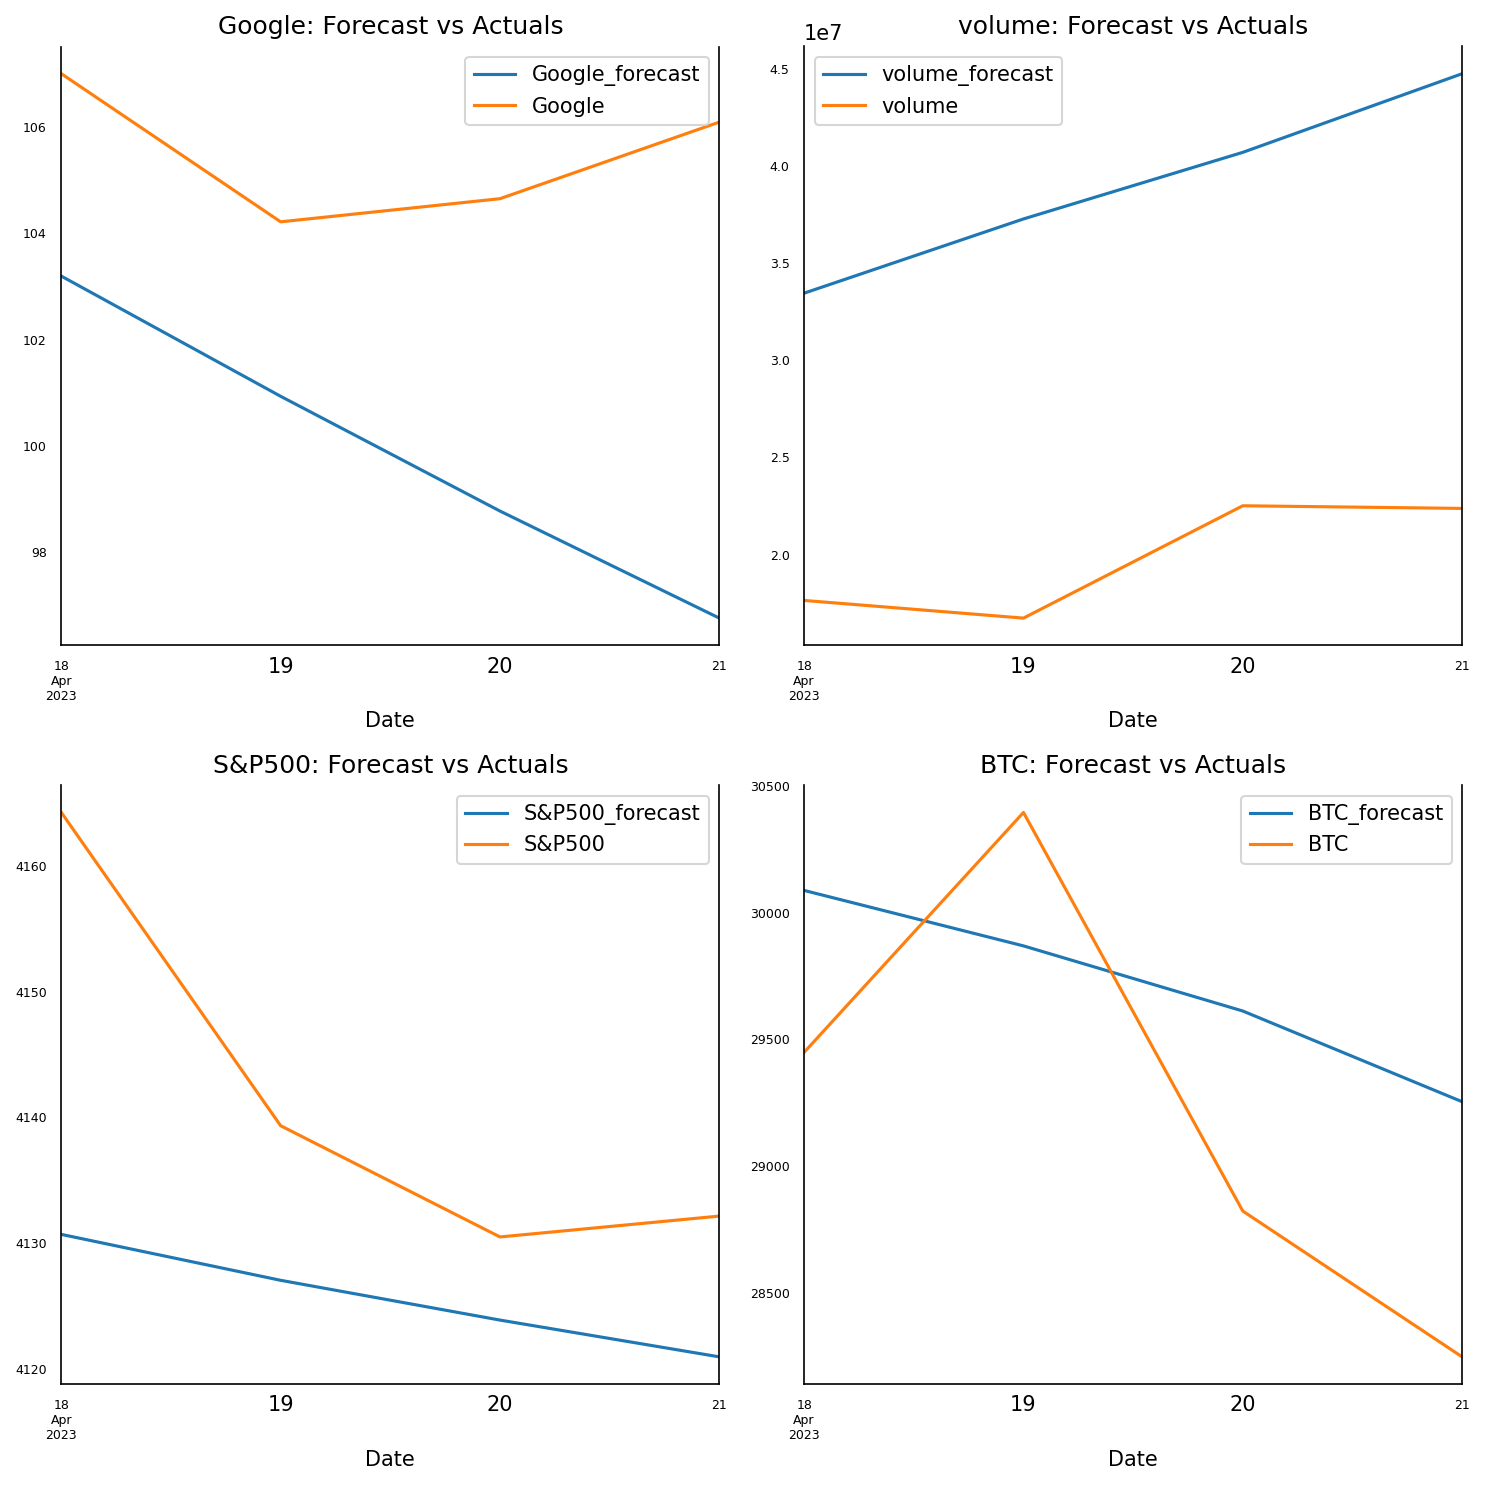

In [34]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();